# Stock Price Classification Exercise

The goal of this exercise is purely an exploratory analysis to determine if we can use a few common technical indicators to predict day-ahead changes in a stock price. We will not be predicting the exact amount of a price increase, just whether the stock increased or decreased the following day. A model like this could be used to inform traders on when to open long positions in specific tickers. We will use one sample stock ticker, ULTI, for the purpose of this analysis. We will test various technical indicators and measure the importance of each one. Then, we will test several classification models to determine if any have predictive ability for day-ahead stock price changes.

## Step 0: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.formula.api import ols
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Import Data

The data we will be using is in a CSV file, stored in the same folder.

In [2]:
# Load data using pandas
stock_data = pd.read_csv("ULTI All Data.csv", index_col = 0, parse_dates=True)
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1998-06-17,8.500,9.3750,8.3125,9.0000,9.0000,66800
1998-06-18,9.250,9.2500,8.7500,8.7500,8.7500,16200
1998-06-19,8.875,8.9375,8.5000,8.9375,8.9375,24000
1998-06-22,8.875,8.8750,8.3750,8.7500,8.7500,25700
1998-06-23,8.375,8.7500,8.2500,8.6875,8.6875,20900


## Step 2: Visualize data

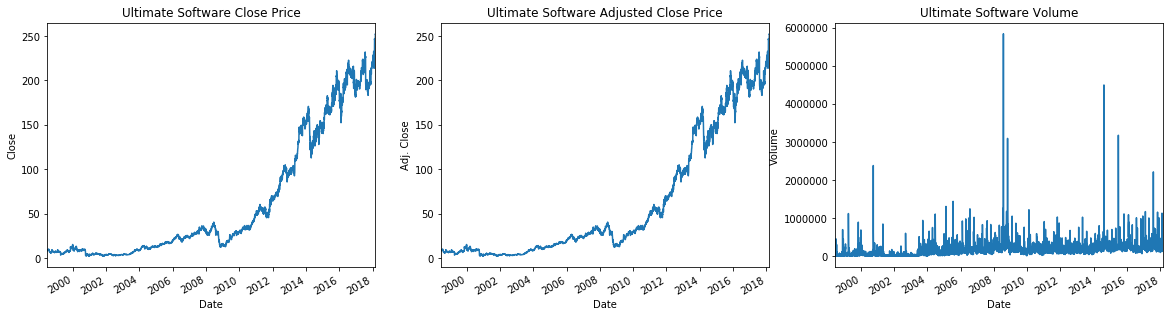

In [3]:
plt.figure(1, figsize=(20,5))

# Plot the close price
plt.subplot(131)
stock_data["Close"].plot()
plt.title("Ultimate Software Close Price")
plt.xlabel("Date")
plt.ylabel("Close")

# Plot the adjusted closing price
plt.subplot(132)
stock_data["Adj Close"].plot()
plt.title("Ultimate Software Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Adj. Close")

# Plot the trading volume
plt.subplot(133)
stock_data["Volume"].plot()
plt.title("Ultimate Software Volume")
plt.xlabel("Date")
plt.ylabel("Volume")

plt.show()

## Step 3: Feature Engineering

### Step 3a: Define the target variable

The first step is to define the target variable. We are trying to build a model that can predict if the stock price is going to increase or decrease on the following day of trading based on the information we have at market close. The target variable will be defined as a binary variable indicating a day over day Increase (True) or day over day Decrease (False).

In [4]:
# Define target variable
stock_data["Next Day Increase"] = stock_data["Close"].shift(-1) - stock_data["Close"]
stock_data["Target"] = stock_data["Next Day Increase"]>0

stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Next Day Increase,Target
Date,,,,,,,,
1998-06-17,8.500,9.3750,8.3125,9.0000,9.0000,66800,-0.2500,False
1998-06-18,9.250,9.2500,8.7500,8.7500,8.7500,16200,0.1875,True
1998-06-19,8.875,8.9375,8.5000,8.9375,8.9375,24000,-0.1875,False
1998-06-22,8.875,8.8750,8.3750,8.7500,8.7500,25700,-0.0625,False
1998-06-23,8.375,8.7500,8.2500,8.6875,8.6875,20900,-0.6875,False


### Step 3b: Bollinger Bands

The first price indicators we will use are called Bollinger Bands. Bollinger Bands consist of a moving average plus a higher line representing the moving average plus a set number of standard deviations above the moving average as well as a lower line representing the same number of standard deviations below the line. The more volatile the stock, the wider the band will be.

A common use is the contrarian strategy, in which the investor sells when it hits the higher band and buys when it hits the lower band. The strategy assumes the price tends to stay within the bands.

We will calculate the ratio of the current day price to each of the bands, using a 60 day time window and 2 standard deviations.

More info on Bollinger Bands: https://www.investopedia.com/articles/technical/102201.asp

In [5]:
# Define parameters for moving average
bb_time_window = 60

# Define moving averages for closing price
stock_data["BB_MA"] = stock_data["Close"].rolling(window=bb_time_window, min_periods=3).mean()

# Define the upper band
stock_data["BB_Upper"] = stock_data["BB_MA"]+2*stock_data["Close"].rolling(window=bb_time_window, min_periods=3).std()
stock_data["BB_Lower"] = stock_data["BB_MA"]-2*stock_data["Close"].rolling(window=bb_time_window, min_periods=3).std()

# Define comparison to upper and lower bands as ratios
stock_data["Close_vs_BB_Upper"] = stock_data["Close"]/stock_data["BB_Upper"]
stock_data["Close_vs_BB_Lower"] = stock_data["Close"]/stock_data["BB_Lower"]

stock_data[["Close","BB_MA","BB_Upper","BB_Lower","Close_vs_BB_Upper","Close_vs_BB_Lower"]].head(11)

,Close,BB_MA,BB_Upper,BB_Lower,Close_vs_BB_Upper,Close_vs_BB_Lower
Date,,,,,,
1998-06-17,9.0000,NaN,NaN,NaN,NaN,NaN
1998-06-18,8.7500,NaN,NaN,NaN,NaN,NaN
1998-06-19,8.9375,8.895833,9.156042,8.635625,0.976131,1.034957
1998-06-22,8.7500,8.859375,9.117069,8.601681,0.959738,1.017243
1998-06-23,8.6875,8.825000,9.095994,8.554006,0.955091,1.015606
1998-06-24,8.0000,8.687500,9.403391,7.971609,0.850757,1.003562
1998-06-25,9.2500,8.767857,9.547528,7.988186,0.968837,1.157960
1998-06-26,9.4375,8.851562,9.714845,7.988280,0.971451,1.181418
1998-06-29,9.0000,8.868056,9.681623,8.054488,0.929596,1.117389


### Step 3c: Moving Average Convergence Divergence

https://www.investopedia.com/terms/m/macd.asp

In [6]:
# Define parameters for MACD
macd_short = 12
macd_long = 26
macd_signal = 9

stock_data["MACD_Short"] = stock_data["Close"].ewm(span=macd_short).mean()
stock_data["MACD_Long"] = stock_data["Close"].ewm(span=macd_long).mean()
stock_data["MACD_Line"] = stock_data["MACD_Short"] - stock_data["MACD_Long"]
stock_data["MACD_Signal"] = stock_data["MACD_Line"].ewm(span=macd_signal).mean() # this is the indicator we will use in the model

stock_data[["Close","MACD_Short","MACD_Long","MACD_Line", "MACD_Signal"]].head()

,Close,MACD_Short,MACD_Long,MACD_Line,MACD_Signal
Date,,,,,
1998-06-17,9.0000,9.000000,9.000000,0.000000,0.000000
1998-06-18,8.7500,8.864583,8.870192,-0.005609,-0.003116
1998-06-19,8.9375,8.893043,8.894375,-0.001333,-0.002385
1998-06-22,8.7500,8.847890,8.854014,-0.006125,-0.003652
1998-06-23,8.6875,8.804312,8.815399,-0.011087,-0.005864


### Step 3d: Relative Strength Index

https://www.investopedia.com/terms/r/rsi.asp

In [7]:
# Define RSI period
rsi_period = 14

# Calculate Open vs Close change
stock_data["Daily Change"] = stock_data["Close"] - stock_data["Open"]

# Calculate RSI
stock_data["AvgGain"] = stock_data["Daily Change"].rolling(window=rsi_period).apply(lambda x: np.mean(x[x>0]) if len(x[x>0])>0 else 0)
stock_data["AvgLoss"] = stock_data["Daily Change"].rolling(window=rsi_period).apply(lambda x: np.abs(np.mean(x[x<0])) if len(x[x<0])>0 else 0)
stock_data["RS"] = stock_data["AvgGain"]/stock_data["AvgLoss"]
stock_data["RS"] = stock_data["RS"].replace([np.inf, -np.inf], 0)
stock_data["RSI"] = 100 - 100/(1+stock_data["RS"]) # this is the indicator we will use in the model

stock_data[["Open", "Close", "Daily Change", "AvgGain", "AvgLoss","RS","RSI"]].iloc[10:20,]

C:\Users\sasth\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
C:\Users\sasth\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if __name__ == '__main__':


,Open,Close,Daily Change,AvgGain,AvgLoss,RS,RSI
Date,,,,,,,
1998-07-01,9.3750,9.250,-0.1250,NaN,NaN,NaN,NaN
1998-07-02,9.2500,9.625,0.3750,NaN,NaN,NaN,NaN
1998-07-06,9.5000,9.625,0.1250,NaN,NaN,NaN,NaN
1998-07-07,9.3750,9.625,0.2500,0.368056,0.250000,1.472222,59.550562
1998-07-08,9.7500,9.500,-0.2500,0.351562,0.250000,1.406250,58.441558
1998-07-09,9.6250,9.625,0.0000,0.351562,0.200000,1.757812,63.739377
1998-07-10,9.6250,9.375,-0.2500,0.392857,0.208333,1.885714,65.346535
1998-07-13,9.5937,9.500,-0.0937,0.392857,0.203117,1.934145,65.918525
1998-07-14,9.6250,9.750,0.1250,0.366071,0.203117,1.802272,64.314667


### Step 3e: Define stochastic oscillators

https://www.investopedia.com/terms/s/stochasticoscillator.asp

In [8]:
# Define stochastics
fast = 14
slow = 3

# We will use both fast and slow oscillators in the model
stock_data["Fast_Oscillator"] = 100*((stock_data["Close"] - stock_data["Low"].rolling(window=fast).min()) / \
                                (stock_data["High"].rolling(window=fast).max()-stock_data["Low"].rolling(window=fast).min()))

stock_data["Slow_Oscillator"] = stock_data["Fast_Oscillator"].rolling(window=slow).mean()

stock_data[["Close","Low","High","Fast_Oscillator","Slow_Oscillator"]].iloc[8:17,]

,Close,Low,High,Fast_Oscillator,Slow_Oscillator
Date,,,,,
1998-06-29,9.0000,7.7500,9.7500,NaN,NaN
1998-06-30,9.3125,9.0000,9.3125,NaN,NaN
1998-07-01,9.2500,9.1250,9.8750,NaN,NaN
1998-07-02,9.6250,9.2500,9.6250,NaN,NaN
1998-07-06,9.6250,9.4375,9.7500,NaN,NaN
1998-07-07,9.6250,9.3750,9.6250,88.235294,NaN
1998-07-08,9.5000,9.3750,9.7500,82.352941,NaN
1998-07-09,9.6250,9.2500,9.7500,88.235294,86.274510
1998-07-10,9.3750,9.3750,9.7500,76.470588,82.352941


In [9]:
print("Number of columns: %s" % len(stock_data.columns))
print(stock_data.columns)

Number of columns: 24
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Next Day Increase', 'Target', 'BB_MA', 'BB_Upper', 'BB_Lower',
       'Close_vs_BB_Upper', 'Close_vs_BB_Lower', 'MACD_Short', 'MACD_Long',
       'MACD_Line', 'MACD_Signal', 'Daily Change', 'AvgGain', 'AvgLoss', 'RS',
       'RSI', 'Fast_Oscillator', 'Slow_Oscillator'],
      dtype='object')


### Step 3f: Exploratory Analysis of Features

In [10]:
# check correlation between the new numeric features and the close price
stock_data[["Close","Close_vs_BB_Upper", "Close_vs_BB_Lower", "MACD_Signal", "RSI", "Fast_Oscillator", "Slow_Oscillator"]].corr()

,Close,Close_vs_BB_Upper,Close_vs_BB_Lower,MACD_Signal,RSI,Fast_Oscillator,Slow_Oscillator
Close,1.000000,0.286142,-0.012588,0.244396,-0.052078,0.077005,0.082153
Close_vs_BB_Upper,0.286142,1.000000,0.002161,0.450977,0.203362,0.449262,0.469345
Close_vs_BB_Lower,-0.012588,0.002161,1.000000,0.004985,0.020190,0.031859,0.027487
MACD_Signal,0.244396,0.450977,0.004985,1.000000,0.129654,0.226990,0.295980
RSI,-0.052078,0.203362,0.020190,0.129654,1.000000,0.386415,0.411757
Fast_Oscillator,0.077005,0.449262,0.031859,0.226990,0.386415,1.000000,0.904592
Slow_Oscillator,0.082153,0.469345,0.027487,0.295980,0.411757,0.904592,1.000000


Looks like none ofthe indicators we have created have a strong correlation with the Close price. This makes it seem they won't have much predictive power in a classification model predicting changes in close price, but we shall see.

### Step 3g: Feature Importance: ANOVA

In the prior step, we attempted to see if any of the technical indicators created had a correlation with the Close price, which is a proxy for our real target variable: Day Ahead Price Increase. Now, we will test to see if any of the indicators have a meaningful relationship with the classification target variable: Day Ahead Price Increase.

First, plot the target variable against some of the technical indicators to judge any relationship visually.

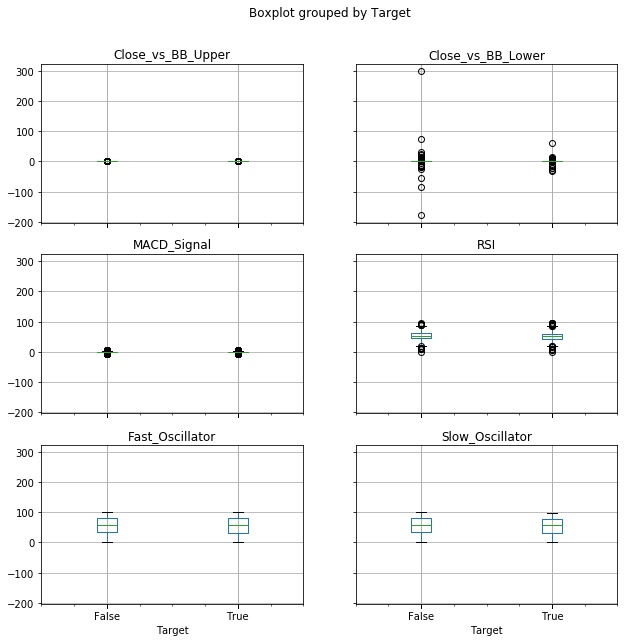

In [11]:
plot_cols = ["Close_vs_BB_Upper", "Close_vs_BB_Lower", "MACD_Signal", "RSI", "Fast_Oscillator", "Slow_Oscillator"]
stock_data.boxplot(column=plot_cols,by='Target',figsize=(10,10))
plt.show()

Does not seem to be any significant difference in True vs False subsets for any of the variables. But, we can do ANOVA to check more detail. We can use ANOVA to see if there is a statistically significant difference between the Target variable True and False, and the distribution of the input variables. Technically, this is a little backwards since we will use the target variable to predict the input, but ANOVA will still give us an indication if there is a meaningful relationship between any of the inputs and a target variable.

Rather than review the entire summary of the OLS Anova model, we will just review the F Statistic for each model for each column to see if there is anything significant.

In [12]:
test_cols = ["Close_vs_BB_Upper", "Close_vs_BB_Lower", "MACD_Signal", "RSI", "Fast_Oscillator", "Slow_Oscillator"]
results_list = []
for col in test_cols:
    formula = col + '~ C(Target)'
    results = ols(formula=formula,data=stock_data).fit()
    results_dict = {"Column":col,
                    "f_pvalue": results.f_pvalue,
                   "rsquared": results.rsquared,
                   "rsquared_adj":results.rsquared_adj}
    results_list.append(results_dict)



In [13]:
anova_results_df = pd.DataFrame(results_list)
anova_results_df

,Column,f_pvalue,rsquared,rsquared_adj
0,Close_vs_BB_Upper,0.443144,1.186269e-04,-0.000083
1,Close_vs_BB_Lower,0.774375,1.657527e-05,-0.000185
2,MACD_Signal,0.991456,2.312016e-08,-0.000202
3,RSI,0.089613,5.823237e-04,0.000380
4,Fast_Oscillator,0.016783,1.155487e-03,0.000954
5,Slow_Oscillator,0.037249,8.771557e-04,0.000675


Based on this, there are a few models that are significant based on the F Statistic (Oscillators and RSI), but not many that have a meaningful R-Squared metric. In further analysis, we should do more digging into each one to determine true significance.

## Step 4: Set up data for modeling

In [14]:
# Remove NaN rows
stock_data = stock_data.dropna()

In [15]:
# Define feature columns
feature_cols = ["Close_vs_BB_Upper", "Close_vs_BB_Lower", "MACD_Signal", "RSI", "Fast_Oscillator", "Slow_Oscillator"]

target = "Target"

# Split data into model inputs (X) and model outputs (Y) 
X = stock_data[feature_cols]
Y = stock_data[target]

In [16]:
# Set up training and testing data sets
train_start = np.min(stock_data.index)
train_end = datetime.datetime(2016,12,31)
test_start = train_end + datetime.timedelta(days=1) # the day after training stops

# Define training set
X_train = X[:train_end]
Y_train = Y[:train_end]

# Define test set
X_test = X[test_start:]
Y_test = Y[test_start:]

## Step 5: Fit Model to Data

In [17]:
# Use decision tree classifier
dt = DecisionTreeClassifier(random_state=0)

# Fit model to data
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [18]:
# Make predictions on test set
dt_preds = dt.predict(X_test)

# Predict probabilities
dt_probs = dt.predict_proba(X_test)

## Step 6: Evaluate model accuracy

In [19]:
# Confusion matrix
print(confusion_matrix(Y_test, dt_preds))

[[ 53  79]
 [ 60 102]]


In [20]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, dt_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, dt_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, dt_preds)))

Accuracy: 52.72 percent
Precision: 56.35 percent
Recall: 62.96 percent


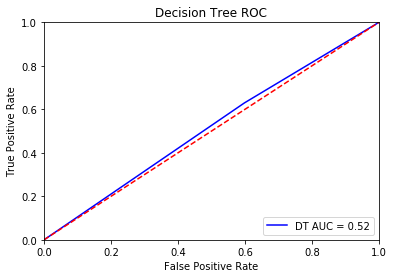

In [21]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, dt_preds)
roc_auc = auc(fpr, tpr)

plt.title('Decision Tree ROC')
plt.plot(fpr, tpr, 'b', label = 'DT AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Just out of curiosity, we can also check feature importances from the decision tree to see if this lines up from the ANOVA results from earlier.

In [22]:
dt_fi = pd.DataFrame(dt.feature_importances_,index=X.columns,columns=["Feature Importance"])
dt_fi.sort_values(by=["Feature Importance"],ascending=False)

,Feature Importance
Slow_Oscillator,0.195153
RSI,0.174354
MACD_Signal,0.164388
Close_vs_BB_Upper,0.163192
Close_vs_BB_Lower,0.157707
Fast_Oscillator,0.145206


This seems to line up with the ANOVA results in the sense that the Slow oscillator and RSI are most important, but relative to all the other features, there is not a big gap. Still hard to say there is any form of meaningful relationship with the target variable.

## Step 7: Test other types of models

### Step 7a: Random Forest

In [23]:
n_trees = 20

rf = RandomForestClassifier(n_estimators=n_trees, random_state=0)

rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
rf_fi = pd.DataFrame(rf.feature_importances_,index=X.columns,columns=["Feature Importance"])
rf_fi.sort_values(by=["Feature Importance"],ascending=False)

,Feature Importance
Close_vs_BB_Upper,0.171786
MACD_Signal,0.167500
Close_vs_BB_Lower,0.167488
RSI,0.166258
Slow_Oscillator,0.165525
Fast_Oscillator,0.161443


In [25]:
# Make predictions on test set
rf_preds = rf.predict(X_test)

# Predict probabilities
rf_probs = rf.predict_proba(X_test)

In [26]:
# Confusion matrix
print(confusion_matrix(Y_test, rf_preds))

[[65 67]
 [82 80]]


In [27]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, rf_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, rf_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, rf_preds)))

Accuracy: 49.32 percent
Precision: 54.42 percent
Recall: 49.38 percent


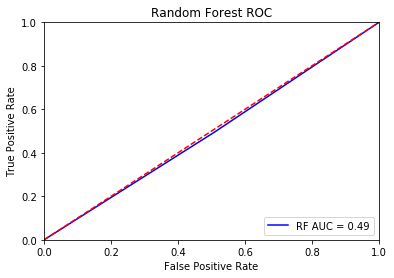

In [28]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, rf_preds)
roc_auc = auc(fpr, tpr)

plt.title('Random Forest ROC')
plt.plot(fpr, tpr, 'b', label = 'RF AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Step 7b: Support Vector Machine

In [29]:
svm = SVC(kernel='rbf',probability=True, random_state=0)

svm.fit(X_train, Y_train)

C:\Users\sasth\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=0, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
# Make predictions on test set
svm_preds = svm.predict(X_test)

# Predict probabilities
svm_probs = svm.predict_proba(X_test)

In [31]:
# Confusion matrix
print(confusion_matrix(Y_test, svm_preds))

[[73 59]
 [99 63]]


In [32]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, svm_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, svm_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, svm_preds)))

Accuracy: 46.26 percent
Precision: 51.64 percent
Recall: 38.89 percent


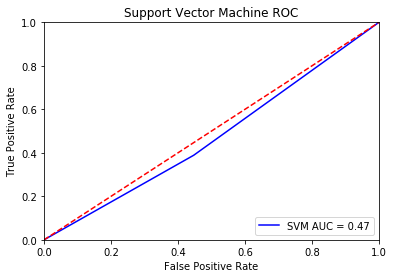

In [33]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, svm_preds)
roc_auc = auc(fpr, tpr)

plt.title('Support Vector Machine ROC')
plt.plot(fpr, tpr, 'b', label = 'SVM AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Step 7c: Neural Network

In [34]:
nnet = MLPClassifier(random_state=0)

nnet.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
# Make predictions on test set
nnet_preds = nnet.predict(X_test)

# Predict probabilities
nnet_probs = nnet.predict_proba(X_test)

In [36]:
# Confusion matrix
print(confusion_matrix(Y_test, nnet_preds))

[[115  17]
 [146  16]]


In [37]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, nnet_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, nnet_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, nnet_preds)))

Accuracy: 44.56 percent
Precision: 48.48 percent
Recall: 9.88 percent


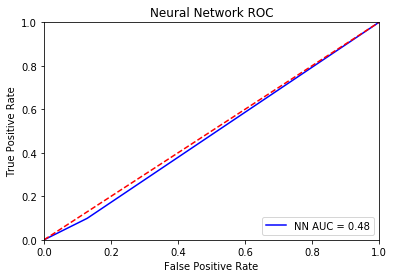

In [38]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, nnet_preds)
roc_auc = auc(fpr, tpr)

plt.title('Neural Network ROC')
plt.plot(fpr, tpr, 'b', label = 'NN AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Step 7d: Summarize results

In [39]:
# Summarize results

models = ["Decision Tree", "Random Forest", "SVM", "Neural Network"]
precision_scores = []
recall_scores = []
accuracy_scores = []
auc_scores =[]

for preds in [dt_preds, rf_preds, svm_preds, nnet_preds]:
    precision_scores.append(precision_score(Y_test, preds))
    recall_scores.append(recall_score(Y_test, preds))
    accuracy_scores.append(accuracy_score(Y_test, preds))
    fpr, tpr, threshold = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
results = pd.DataFrame({"Accuracy" : accuracy_scores, 
                        "Precision" : precision_scores,  
                       "Recall" : recall_scores, 
                        "AUC" : auc_scores}, index=models)
    
results

,Accuracy,Precision,Recall,AUC
Decision Tree,0.527211,0.563536,0.629630,0.515572
Random Forest,0.493197,0.544218,0.493827,0.493126
SVM,0.462585,0.516393,0.388889,0.470960
Neural Network,0.445578,0.484848,0.098765,0.484989


## Conclusion

Overall, we can conclude that none of the models tested performed much better than random chance. Some even performed worse than random chance in terms of predictig day ahead stock price movements. Interestingly enough, the decision tree seemed to perform better than the more advanced models, indicating some level of overfitting to the training set. Obviously, stock price prediction is a very difficult, non-linear problem that would require better predictors and models than we explored today. But it was a helpful exercise to walk through the step from beginning to end of how to build and test a model on a real dataset.

## Future Work

Future work could include many different phases of work:
1. Trying a new stock ticker
2. Performing model cross validation and running the model evaluation over multiple time periods instead of just one
3. Hyperparameter tuning for each model to identify optimal model parameters
4. More feature engineering, testing out different input variables and other technical indicators
5. More rigorous feature selection methods